In [1]:
from src.utils.results_utils import *
import pandas as pd

# Ethnicity model

In [2]:
df_ethnicity = pd.read_csv('data/name_ethnicity.csv')
df_ethnicity.sample(10)

,Name,Country
1816,Jason,English-Speaking
2445,Margaret,English-Speaking
3340,Sebastiano,Romance
2007,Katarzyna,Slavic
3474,Song,East Asian
564,COULON,Romance
2237,Leonel,Hispanic
3287,Saeko,East Asian
3505,Steffi,Germanic
3848,Vichai,Southeast Asian


In [3]:
# Grouping by 'Country' and summing the occurrences
region_counts = df_ethnicity.groupby('Country').size()  # Count the number of names per country
region_counts.sort_values(ascending=False).head(14)

Country
Slavic                648
Germanic              626
English-Speaking      603
East Asian            486
Romance               480
Hispanic              376
Nordic                285
Oceania               197
South Asian           113
Middle Eastern         93
Sub-Saharan Africa     90
Southeast Asian        47
Baltic                 46
North Africa           25
dtype: int64

Encode the Coutries as numbers :

In [4]:
class ColumnEncoder:
    def __init__(self, column_name):
        """
        Initialize the encoder for a specific column.
        """
        self.column_name = column_name
        self.legend = None  # To store the legend of encoded values

    def fit_transform(self, df):
        """
        Encodes the column in the DataFrame as integers and stores the legend.
        """
        if self.column_name not in df.columns:
            raise ValueError(f"Column '{self.column_name}' not found in DataFrame.")
        
        # Factorize the column and store the legend
        df[self.column_name], self.legend = pd.factorize(df[self.column_name])
        return df

    def get_legend(self):
        """
        Generates a DataFrame containing the legend of encoded values.
        """
        if self.legend is None:
            raise ValueError("The encoder has not been fitted. Call `fit_transform` first.")
        
        legend_df = pd.DataFrame({
            'Encoded Value': range(len(self.legend)),
            self.column_name: self.legend
        })
        return legend_df

In [5]:
# Encode the column in the DataFrame
encoder = ColumnEncoder(column_name='Country')
df_ethnicity = encoder.fit_transform(df_ethnicity)

# Get the legend 
legend_df = encoder.get_legend()
print("\nLegend:")
legend_df.head(14)



Legend:


,Encoded Value,Country
0,0,Hispanic
1,1,Nordic
2,2,Germanic
3,3,English-Speaking
4,4,Slavic
5,5,Middle Eastern
6,6,North Africa
7,7,Romance
8,8,Sub-Saharan Africa
9,9,South Asian


In [6]:
df_ethnicity.sample(10)

,Name,Country
2620,Midori,10
2266,Linda,2
2316,Lucas,3
3060,Radomir,4
1322,Giancarlo,7
973,Edwin,3
3010,Pierluigi,7
2035,Kazumi,10
1283,Geoff,12
3949,Winthrop,0


## 1. Name Lenght, Vowel/Consonant Count and Ratio, Soundex and N-Gram

In [7]:
from jellyfish import soundex
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

class EthnicityDataProcessor:
    def __init__(self, ngram_range=(2, 3)):
        """
        Initialize the processor with optional n-gram range for text vectorization.
        """
        self.ngram_range = ngram_range
        self.vectorizer = None

    @staticmethod
    def analyze_name(name):
        if not isinstance(name, str) or not name.strip():  # Handle empty or invalid names
            return pd.Series({
                'Length': 0,  
                'Vowel Count': 0,
                'Consonant Count': 0,
                'Vowel/Consonant Ratio': 0,
            })

        vowels = set('aeiouyAEIOUY')
        consonants = set('bcdfghjklmnpqrstvwxyzBCDFGHJKLMNPQRSTVWXYZ')
        length = len(name)
        vowel_count = sum(1 for char in name if char in vowels)
        consonant_count = sum(1 for char in name if char in consonants)
        return pd.Series({
            'Length': length,
            'Vowel Count': vowel_count,
            'Consonant Count': consonant_count,
            'Vowel/Consonant Ratio': vowel_count / consonant_count if consonant_count > 0 else 0,
        })


    @staticmethod
    def add_diacritic_columns(names, diacritics="àáâäæãåāèéêëēėęìíîïīįìòóôöøōõùúûüūçÿńñß"):
        """
        Add binary columns for each diacritic in the names.
        """
        diacritic_set = set(diacritics)
        diacritic_columns = {
            f"{diacritic}": names.apply(lambda name: 1 if diacritic in name.lower() else 0)
            for diacritic in diacritic_set
        }
        diacritic_df = pd.DataFrame(diacritic_columns)
        # Drop columns where no diacritics are found
        diacritic_df = diacritic_df.loc[:, (diacritic_df.sum(axis=0) > 0)]
        return diacritic_df

    @staticmethod
    def add_soundex_encoding(names):
        """
        Add Soundex encoding to the names.
        """
        soundex_series = names.apply(soundex)
        return pd.get_dummies(soundex_series, prefix='Soundex')

    def add_ngram_features(self, names):
        """
        Add n-gram features for the names using character-based n-grams.
        """
        if self.ngram_range is not None:
            self.vectorizer = CountVectorizer(analyzer='char', ngram_range=self.ngram_range)
            ngram_features = self.vectorizer.fit_transform(names)
            return pd.DataFrame(ngram_features.toarray(), columns=self.vectorizer.get_feature_names_out())
        return pd.DataFrame()

    def process(self, df):
        """
        Process the input DataFrame to add all the features.
        """
        # Analyze names
        df = df.join(df['Name'].apply(self.analyze_name))

        # Add diacritic columns
        diacritic_df = self.add_diacritic_columns(df['Name'])
        df = df.join(diacritic_df)

        # Add Soundex encoding
        soundex_df = self.add_soundex_encoding(df['Name'])
        df = pd.concat([df, soundex_df], axis=1)

        # Add n-gram features
        ngram_df = self.add_ngram_features(df['Name'])
        df = pd.concat([df, ngram_df], axis=1)

        return df

In [8]:
# Process df_ethnicity
processor = EthnicityDataProcessor(ngram_range=(2, 3))
df_ethnicity_processed = processor.process(df_ethnicity)

df_ethnicity_processed.head()

,Name,Country,Length,Vowel Count,Consonant Count,Vowel/Consonant Ratio,ë,ã,è,ä,...,üdi,ün,ünt,ür,ürg,üri,üs,üse,üz,üza
0,ALDAIR,0,6.0,3.0,3.0,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ALEX,0,4.0,2.0,2.0,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ALEXANDRE,0,9.0,4.0,5.0,0.8,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ALINE,0,5.0,3.0,2.0,1.5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AMARAL,0,6.0,3.0,3.0,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Par rapport à Soundex :** Phonetic algorithm designed to index words (particularly names) based on their pronunciation rather than their spelling. This is especially useful when trying to find names that sound similar but are spelled differently.

## 2. Scaling features and PCA

In [9]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

class PCAProcessor:
    def __init__(self, n_components=100):
        """
        Initialize the PCAProcessor with a specified number of components.
        """
        self.n_components = n_components
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=n_components)
        self.pca_features = None
        self.explained_variance_ratio_ = None

    def fit_transform(self, df, drop_columns=None):
        """
        Fit the PCA model and transform the input DataFrame.
        """
        # Drop specified columns if provided
        if drop_columns:
            df_features = df.drop(columns=drop_columns)
        else:
            df_features = df.copy()

        # Standardize the data
        features_scaled = self.scaler.fit_transform(df_features)

        # Apply PCA
        self.pca_features = self.pca.fit_transform(features_scaled)
        self.explained_variance_ratio_ = self.pca.explained_variance_ratio_

        # Create a DataFrame for the PCA-transformed data
        pca_columns = [f'PC{i+1}' for i in range(self.n_components)]
        return pd.DataFrame(self.pca_features, columns=pca_columns, index=df.index)

    def plot_explained_variance(self):
        """
        Plot the cumulative explained variance by PCA components.
        """
        if self.explained_variance_ratio_ is None:
            raise ValueError("PCA has not been fitted. Run `fit_transform` first.")
        
        plt.figure(figsize=(8, 5))
        plt.plot(self.pca.explained_variance_ratio_.cumsum())
        plt.title("Cumulative Explained Variance by PCA Components")
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance")
        plt.grid()
        plt.show()

    def merge_with_original(self, original_df, pca_df, keep_columns):
        """
        Merge the PCA-transformed DataFrame with the original DataFrame.
        """
        # Retain only specified columns and merge with PCA DataFrame
        merged_df = pd.concat([original_df[keep_columns], pca_df], axis=1)
        return merged_df

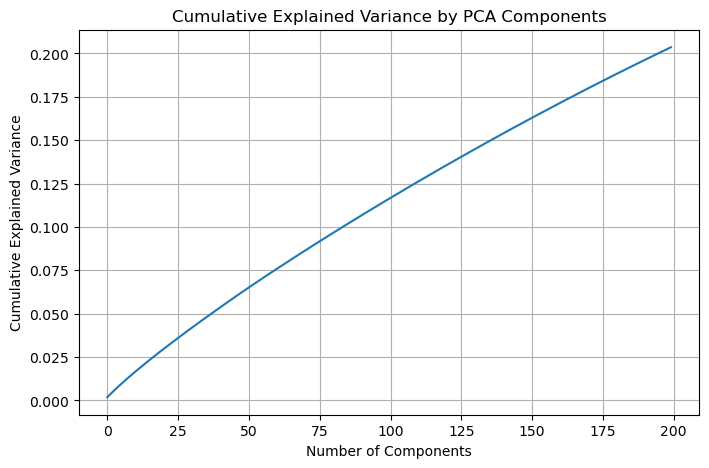

,Name,Country,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC191,PC192,PC193,PC194,PC195,PC196,PC197,PC198,PC199,PC200
0,ALDAIR,0,-0.136386,-0.144312,-0.484542,-0.201384,0.251960,-0.545876,0.905840,-0.299005,...,1.248912,0.578360,-0.648833,-0.869177,0.673114,0.214382,-3.510953,-0.758941,-0.070852,-1.715947
1,ALEX,0,-0.162087,-0.156865,-0.797616,-0.998259,-0.531845,-0.860205,0.625218,1.752905,...,0.141487,-0.085171,-1.153244,0.205301,0.570740,0.344306,0.302904,0.706563,-0.962442,-1.204742
2,ALEXANDRE,0,-0.349820,-0.517045,-1.083715,-1.699984,-3.431447,-1.573741,-0.708614,6.067488,...,-1.734174,-0.091075,-0.996797,1.696057,2.732772,1.219499,-0.277309,1.382430,-1.497536,-1.744259
3,ALINE,0,-0.168600,-0.114307,-0.556922,-0.493999,0.102474,-0.724070,0.982801,0.485632,...,0.245610,0.482153,-0.669151,0.574891,0.081718,0.342350,-0.078725,-0.024546,-0.013398,-0.496227
4,AMARAL,0,-0.008474,-0.141571,-0.382267,-0.263549,-0.314503,-0.774048,0.439309,0.473846,...,0.572130,-0.013375,0.996149,0.554017,0.639215,-0.383337,0.121820,-0.868497,-0.402998,0.048271


In [10]:
# Choice of number of PCA kept cmponents
n=200

# PCAProcessor
pca_processor = PCAProcessor(n_components=n)
pca_df = pca_processor.fit_transform(df_ethnicity_processed, drop_columns=['Name', 'Country']) # Fit PCA and transform the data
pca_processor.plot_explained_variance() # Plot explained variance
df_ethnicity_pca = pca_processor.merge_with_original(df_ethnicity_processed, pca_df, keep_columns=['Name', 'Country']) # Merge PCA components with original columns ('Name' and 'Country')

df_ethnicity_pca.head()

In [11]:
from sklearn.model_selection import train_test_split

# Define features and targets
X = df_ethnicity_pca.drop(columns=['Name','Country'])
y = df_ethnicity_pca['Country']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


print(f"There are {X_train.shape[0]} samples in the training set.")
print(f"There are {X_test.shape[0]} samples in the testing set.")

There are 3292 samples in the training set.
There are 823 samples in the testing set.


In [12]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# columns = ["Constant"] + list(df_ethnicity_pca.drop(columns=['Name','Country']).columns) 
# df_X_train = pd.DataFrame(X_train, columns=columns)

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Initialize the classifier
model = RandomForestClassifier(random_state=42)

# Train the classifier
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Detailed classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Accuracy: 0.4204131227217497
Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.20      0.24        70
           1       0.41      0.18      0.25        51
           2       0.34      0.46      0.39       135
           3       0.28      0.39      0.33       109
           4       0.47      0.67      0.56       127
           5       0.00      0.00      0.00        24
           6       0.00      0.00      0.00         7
           7       0.36      0.38      0.37       100
           8       0.00      0.00      0.00        13
           9       0.00      0.00      0.00        22
          10       0.74      0.82      0.78       113
          11       0.00      0.00      0.00         5
          12       0.17      0.03      0.05        38
          13       0.50      0.11      0.18         9

    accuracy                           0.42       823
   macro avg       0.26      0.23      0.22       823
weighted avg       0.38     

/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ça run pas, dans l'idée c'est une cross validation pour tuner n (le nombre de principal componants qu'on va prendre)

In [14]:
# from sklearn.decomposition import PCA
# from sklearn.model_selection import cross_val_score
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error
# import matplotlib.pyplot as plt
# import numpy as np

# # List to store results
# results = []

# # Iterate over the number of PCA components
# for n in range(1, 1500):
#     # Apply PCA with n components
#     pca = PCA(n_components=n)
#     X_reduced = pca.fit_transform(X)

#     # Train and evaluate the model with cross-validation
#     model = RandomForestClassifier()
#     scores = cross_val_score(
#         model, X_reduced, y, cv=5, scoring='neg_mean_squared_error'
#     )
#     # Store the mean of absolute MSE scores
#     mean_mse = -np.mean(scores)
#     results.append((n, mean_mse))

# # Find the best number of components
# best_n, best_score = min(results, key=lambda x: x[1])  # Minimize error
# print(f"Best number of components: {best_n}, Lowest MSE: {best_score}")

# # Plot results
# plt.plot([r[0] for r in results], [r[1] for r in results])
# plt.xlabel('Number of Components')
# plt.ylabel('Mean Squared Error (MSE)')
# plt.title('Model Performance vs Number of Components')
# plt.show()

## 4. Predict ethnicities of the character dataset

In [19]:
df_character = pd.read_csv('data/cleaned.csv')
df_character.sample(10)

,Wikipedia_ID,Name,Languages,Country,Genres,Character_name,Sex,Actor_age,Release_date
144902,1613987,Hairspray,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01q03"": ""Cult"", ""/m/04t36"": ""Musical"", ""/...",Von,M,53.0,1988-02-26
4945,35412577,Down the Road Again,"{""/m/02h40lc"": ""English Language""}","{""/m/0d060g"": ""Canada""}","{""/m/07s9rl0"": ""Drama""}",Selina,F,63.0,2011-10-21
11444,761458,Bulldog Drummond's Third Round,{},"{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/06ppq"": ""Sil...",Peterson,M,NaN,1925
5657,7081414,Starting Out in the Evening,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02l7c8"": ""Romance Film"", ""/m/07s9rl0"": ""D...",Ariel,F,40.0,2007-11-02
95831,9880808,Impure Blood,"{""/m/0k0sb"": ""Serbian language""}","{""/m/06swt"": ""Serbia and Montenegro"", ""/m/018j...","{""/m/07s9rl0"": ""Drama""}",Sofija,F,NaN,1996-04-15
113527,27656617,Haywire,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/02kdv5l"": ""Actio...",Aaron,M,31.0,2011-11-07
56176,36000792,4 Days in May,"{""/m/06b_j"": ""Russian Language"", ""/m/04306rv"":...","{""/m/07t21"": ""Ukraine"", ""/m/06bnz"": ""Russia"", ...","{""/m/07s9rl0"": ""Drama"", ""/m/082gq"": ""War film""}",Der,M,NaN,2011-09-29
103366,11191665,My Favorite Season,"{""/m/064_8sq"": ""French Language""}","{""/m/0f8l9c"": ""France""}","{""/m/02h8pkk"": ""Family Drama"", ""/m/07s9rl0"": ""...",Bruno,M,44.0,1993
115896,488484,Pitch Black,"{""/m/0jzc"": ""Arabic Language"", ""/m/02h40lc"": ""...","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Paris,M,41.0,2000-02-18
13234,1612611,Encrypt,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ...",Hernandez,F,NaN,2003-06-14


In [20]:
character_names = pd.DataFrame(df_character[['Character_name']].rename(columns={'Character_name': 'Name'})).drop_duplicates()
print(character_names.size)
character_names.head()

38401


,Name
0,Akooshay
1,Melanie
2,Williams
3,Jericho
4,Bashira


In [ ]:
# Verify the data type
print(character_names['Name'].apply(type).value_counts())

Name
<class 'str'>    38401
Name: count, dtype: int64


In [22]:
# Process character_names
processor = EthnicityDataProcessor(ngram_range=(2, 3))
character_names_processed = processor.process(character_names)

character_names_processed.sample(10)

,Name,Length,Vowel Count,Consonant Count,Vowel/Consonant Ratio,ù,ó,ë,û,â,...,že,žen,́n,́nd,сh,сhe,сht,’s,“w,“wo
18409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87487,Voleur,6.0,3.0,3.0,1.000000,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13789,Joao,4.0,3.0,1.0,3.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128684,Peazant,7.0,3.0,4.0,0.750000,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75474,Brythle,7.0,2.0,6.0,0.333333,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140483,Anthi,5.0,2.0,3.0,0.666667,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157438,Lettner,7.0,2.0,5.0,0.400000,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(character_names_processed.isna().sum())  # Check for NaN values
print(character_names_processed[character_names_processed['Name'].isna()])  # Inspect rows with NaN in 'Name'

Name                     24267
Length                   24267
Vowel Count              24267
Consonant Count          24267
Vowel/Consonant Ratio    24267
                         ...  
сhe                      24267
сht                      24267
’s                       24267
“w                       24267
“wo                      24267
Length: 14381, dtype: int64
      Name  Length  Vowel Count  Consonant Count  Vowel/Consonant Ratio   ö  \
37     NaN     NaN          NaN              NaN                    NaN NaN   
49     NaN     NaN          NaN              NaN                    NaN NaN   
54     NaN     NaN          NaN              NaN                    NaN NaN   
78     NaN     NaN          NaN              NaN                    NaN NaN   
79     NaN     NaN          NaN              NaN                    NaN NaN   
...    ...     ...          ...              ...                    ...  ..   
38391  NaN     NaN          NaN              NaN                    NaN NaN   

: 

In [ ]:
# PCA Processor
pca_processor = PCAProcessor(n_components=n)
character_names_pca = pca_processor.fit_transform(character_names_processed, drop_columns=['Name']) # Fit PCA and transform the data
pca_processor.plot_explained_variance() # Plot explained variance
character_names_pca = pca_processor.merge_with_original(character_names_processed, character_names_pca, keep_columns=['Name']) # Merge PCA components with original columns 

character_names_pca.head()

In [ ]:
scaler = StandardScaler()
character_names_pca = scaler.fit_transform(character_names_pca.drop(columns='Name'))
character_names_pca = sm.add_constant(character_names_pca)

sample_character_names = character_names.iloc[:5000, :]

sample_character_names['Country'] = model.predict(character_names_pca)


/var/folders/qy/f2gycl5x4rz0443jgmxn93_80000gn/T/ipykernel_40331/568152837.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_character_names['Country'] = model.predict(character_names_pca)


In [ ]:
sample_character_names.head()

,Name,Country
0,Akooshay,4
1,Melanie,2
2,Williams,2
3,Jericho,3
4,Bashira,2
